# Twitter Sentiment Classification

### Loading Twitter Classification Dataset

### Dataset Description
The dataset used for this project is the Sentiment140 [4] dataset created by Stanford University students. It is a comma separated file (CSV) consisting of 1.6 million English language tweets. The data file format contains 6 fields :

#### 0 - the polarity of the tweet (0 - negative, 4 - positive)
#### 1 - the id of the tweet (2087)
#### 2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
#### 3 - the query (lyx). If there is no query, then this value is NO_QUERY. 4 - the user that tweeted (robotickilldozr)
#### 5 - the text of the tweet (Lyx is cool)

In [1]:
import os
import nltk                                                          
import re                                                            
import pandas as pd                                                  
import numpy as np                                                   
from sklearn.model_selection import train_test_split                 
from sklearn.feature_extraction.text import TfidfVectorizer          
from sklearn.naive_bayes import MultinomialNB                        
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

path = os.getcwd()
dataset = pd.read_csv(path+ '/training.csv', encoding='ISO-8859-1', header=None).sample(60000)
print("Our data set looks like that:")
dataset.head()

Our data set looks like that:


,0,1,2,3,4,5
141385,0,1881255126,Fri May 22 04:06:31 PDT 2009,NO_QUERY,sofiejenkinson,@PerriLewis wish I was coming. boooo
1238085,4,1993190065,Mon Jun 01 09:58:43 PDT 2009,NO_QUERY,jewelfyre,"when we were grilling the other day, Julia kep..."
1481832,4,2067144825,Sun Jun 07 11:49:43 PDT 2009,NO_QUERY,alayv,More energy today. I wonder if it's the worko...
1542616,4,2181103669,Mon Jun 15 11:22:20 PDT 2009,NO_QUERY,almatic,"@anthoro ...Bron is just more passionate, alre..."
370553,0,2050171004,Fri Jun 05 18:11:36 PDT 2009,NO_QUERY,idazzled,all plans cancelled today. Nenek hospitalised


# Question 1: text pre-processing

##### Several preprocessing tasks need to be carried out to convert the tweet into a form which can be easily processed. The following steps have been carried out:

##### 1) Convert URLs
##### 2) Convert Twitter Handle
##### 3) Convert Hashtags
##### 4) Convert Repeating Letters
##### 5) Convert to Stem
##### 6) Emoticons

### Tokenization and Normalization

In [2]:
def preprocess(tweet):
    # Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', 'URL', tweet)

    # Convert @username to __USERHANDLE
    tweet = re.sub('@[^\s]+', '__USERHANDLE', tweet)

    # Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)

    # trim
    tweet = tweet.strip('\'"')

    # Repeating words like hellloooo
    repeat_char = re.compile(r"(.)\1{1,}", re.IGNORECASE)
    tweet = repeat_char.sub(r"\1\1", tweet)

    # Emoticons
    emoticons = \
        [
            ('__positive__', [':-)', ':)', '(:', '(-:', \
                              ':-D', ':D', 'X-D', 'XD', 'xD', \
                              '<3', ':\*', ';-)', ';)', ';-D', ';D', '(;', '(-;', ]), \
            ('__negative__', [':-(', ':(', '(:', '(-:', ':,(', \
                              ':\'(', ':"(', ':((', 'D:']), \
            ]

    def replace_parenthesis(arr):
        return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]

    def join_parenthesis(arr):
        return '(' + '|'.join(arr) + ')'

    emoticons_regex = [(repl, re.compile(join_parenthesis(replace_parenthesis(regx)))) \
                       for (repl, regx) in emoticons]

    for (repl, regx) in emoticons_regex:
        tweet = re.sub(regx, ' ' + repl + ' ', tweet)

    # Convert to lower case
    tweet = tweet.lower()
    
    # Stop Words
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(tweet) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    tweet = ' '.join(filtered_sentence)

    return tweet


# Stemming of Tweets

def stem(tweet):
    stemmer = nltk.stem.PorterStemmer()
    tweet_stem = ''
    words = [word if (word[0:2] == '__') else word.lower() \
             for word in tweet.split() \
             if len(word) >= 3]
    words = [stemmer.stem(w) for w in words]
    tweet_stem = ' '.join(words)
    return tweet_stem                                     

### Class distribution, terms frequency for the different sentiments

In [3]:
#filtering the sentiments from the data
#positive sentiments
df1 = dataset[dataset[0] == 4].iloc[:,5].values
possitive_sentiment = [stem(preprocess(tweet)) for tweet in df1]

vec1 = TfidfVectorizer(min_df=5, max_df=0.95, sublinear_tf = True,use_idf = True,ngram_range=(1, 2))   
#possitive vec
possitive_sentiment_vec = vec1.fit_transform(possitive_sentiment)
feature_names = vec1.get_feature_names()

df = pd.DataFrame(possitive_sentiment_vec.T.todense(), index=feature_names)
#Export data to csv
#open('train_positive_freq.csv').close()
#df.to_csv(path + '\\train_positive_freq.csv')
print("tf-idf scores in a matrix for possitive sentiment:")
df

tf-idf scores in a matrix for possitive sentiment:


,0,1,2,3,4,5,6,7,8,9,...,29975,29976,29977,29978,29979,29980,29981,29982,29983,29984
00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100 00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100 follow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100th,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#negative sentiments
df2 = dataset[dataset[0] == 0].iloc[:,5].values
negative_sentiment = [stem(preprocess(tweet)) for tweet in df2]
#negative vec
vec2 = TfidfVectorizer(min_df=5, max_df=0.95, sublinear_tf = True,use_idf = True,ngram_range=(1, 2))   
negative_sentiment_vec = vec2.fit_transform(negative_sentiment)
feature_names = vec2.get_feature_names()

df = pd.DataFrame(negative_sentiment_vec.T.todense(), index=feature_names)
#Export data to csv
#df.to_csv(path + '\\train_negative_freq.csv')
print("tf-idf scores in a matrix for negative sentiment:")
df

tf-idf scores in a matrix for negative sentiment:


,0,1,2,3,4,5,6,7,8,9,...,30005,30006,30007,30008,30009,30010,30011,30012,30013,30014
00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data exploration

### Class Distribution plot
* The X axis is the data labels (0-Negative , 1-Possitive) 
* The Y axis is number of tweets related to the one of the grops (Negative ,Possitive)

In [5]:
import matplotlib.pyplot as plt
# objects = ('Negative', 'Possitive')
# y_pos = np.arange(len(objects))
# performance = [df1.size/dataset.size,df2.size/dataset.size]
# plt.bar(y_pos, performance, align='center', alpha=0.5)
# plt.xticks(y_pos, objects)
# plt.ylabel('Precentage Of twitts')
# plt.title('Sentiments Distribution')
# plt.show()
dataset[0].value_counts().sort_index().plot.bar()


### Class Distribution plot
* The X axis is the length of the tweets
* The Y axis is the frequency that tweet t has length l

Text length:


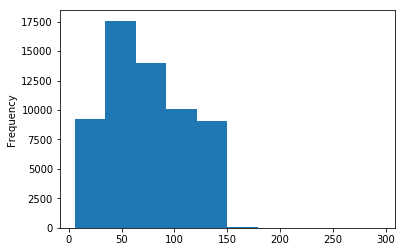

In [6]:
print("Text length:")
dataset[5].str.len().plot.hist()

### Spliting the data to train and test (80% - train , 20% - test)

In [7]:
import pylab as pl

X = dataset.iloc[:, 5].values     
X = pd.Series(X)                  
y = dataset.iloc[:, 0].values
print(y)
X = [stem(preprocess(tweet)) for tweet in X] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

[0 4 4 ... 0 0 0]


# Question 2: Training a machine learning model

### Model 1 : Multinomial Naive Bayes classifier using 2gram
We tune the alpha parameter (additive smoothing parameter) of the Multinomial Naive Bayes. 

Multinomial Naive Bayes with default alpha (alpha = 1)

In [8]:
#tfidf vector 
vec = TfidfVectorizer()
vec.fit(X_train)
X_train_vec = vec.transform(X_train)
nb = MultinomialNB()
nb.fit(X_train_vec,y_train)
X_test_vec = vec.transform(X_test)
pred = nb.predict(X_test_vec)

print(metrics.accuracy_score(y_test, pred))
print("mean: "+str(y_test.mean()))
print("1-mean: "+str(1-y_test.mean()))


0.7465833333333334
mean: 2.006666666666667
1-mean: -1.0066666666666668


Multinomial Naive Bayes with alpha = 0.5

In [9]:
nb = MultinomialNB(alpha=0.5)
nb.fit(X_train_vec,y_train)
pred2 = nb.predict(X_test_vec)

print(metrics.accuracy_score(y_test, pred2))

0.7384166666666667


Multinomial Naive Bayes with alpha = 0.8

In [10]:
nb = MultinomialNB(alpha=0.8)
nb.fit(X_train_vec,y_train)
pred3 = nb.predict(X_test_vec)

print(metrics.accuracy_score(y_test, pred3))

0.7450833333333333


## Confusion Matrix

Confusion Matrix:
[[4551 1429]
 [1612 4408]]


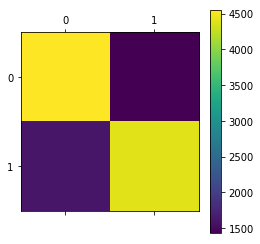

             precision    recall  f1-score   support

          0       0.74      0.76      0.75      5980
          4       0.76      0.73      0.74      6020

avg / total       0.75      0.75      0.75     12000



In [11]:
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test, pred))
#[[128420  31369]
# [ 33164 127047]]
cm = metrics.confusion_matrix(y_test, pred)
pl.matshow(cm)
#pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()

print(metrics.classification_report(y_test, pred))

### Model 2 : Recurrent Neural Network using 2gram to vec
#### We will use a RNN for sentiment analysis because we care for the sequence in the data.

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.layers import Dropout
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
X = pad_sequences(X) # padding our text vector so they all have the same length
y = pd.get_dummies(y).values
print("The data vector:\n")
print(X[:5])

C:\Users\PC\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The data vector:

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    1   44   38  286]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0 1770
     4 1091  117 1131   10 2783   10]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
  1205   13  175 1319    5   48   15]
 [   0    0    0    0    0    0    0    0    0    0    0    0    1 2045
   111  412  557   93   26 2784  818]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0  247  780   13]]


### Creating model¶

In [13]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
batch_size = 32
epochs = 3
model = Sequential()
model.add(Embedding(5000, 256, input_length=X.shape[1]))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
model.add(LSTM(256, dropout=0.3, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 21, 256)           1280000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 21, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 21, 256)           525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 2,331,138
Trainable params: 2,331,138
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Training model

In [15]:
history = model.fit(X_train, y_train, epochs=epochs,validation_split=0.1, batch_size=batch_size, verbose=1,callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

C:\Users\PC\AppData\Roaming\Python\Python36\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 43200 samples, validate on 4800 samples
Epoch 1/3
43200/43200 [==============================] - 330s 8ms/step - loss: 0.5272 - accuracy: 0.7363 - val_loss: 0.4933 - val_accuracy: 0.7610
Epoch 2/3


C:\Users\PC\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


43200/43200 [==============================] - 327s 8ms/step - loss: 0.4559 - accuracy: 0.7871 - val_loss: 0.4877 - val_accuracy: 0.7640
Epoch 3/3
12000/12000 [==============================] - 27s 2ms/step
Accuracy: 76.03%


## Confusion Matrix

12000/12000 [==============================] - 9s 761us/step
Confusion matrix:
[[4588 1471]
 [1405 4536]]
mean: 0.5
1-mean: 0.5


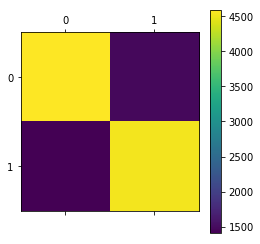

             precision    recall  f1-score   support

          0       0.77      0.76      0.76      6059
          4       0.76      0.76      0.76      5941

avg / total       0.76      0.76      0.76     12000



In [16]:
def pred(score):
    p=[0,0]
    if score[0] < 0.5:
        p[0]=0
    else:
        p[0]=1
    if score[1] < 0.5:
            p[1]=0
    else: 
            p[1]=1
    return p

def valp(p):
    if p[0]==1 and p[1]==0:
        return 0
    else:
        return 4

y_pred_1d = []
y_test_1d = list(y_test)
scores = model.predict(X_test, verbose=1, batch_size=8000)
y_pred_1d = [pred(score) for score in scores]


y_test_v = [valp(p) for p in y_test]
y_pred_v = [valp(p) for p in y_pred_1d]
cm = metrics.confusion_matrix(y_test_v, y_pred_v)
print("Confusion matrix:")
print(cm)
print("mean: "+str(y_test.mean()))
print("1-mean: "+str(1-y_test.mean()))
pl.matshow(cm)
#pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()
print(metrics.classification_report(y_test_v, y_pred_v))

## Training and validation accuracy/loss

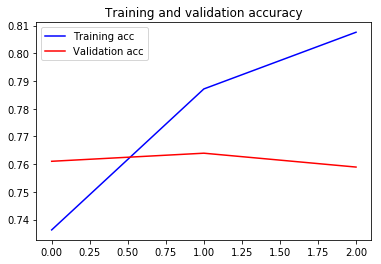

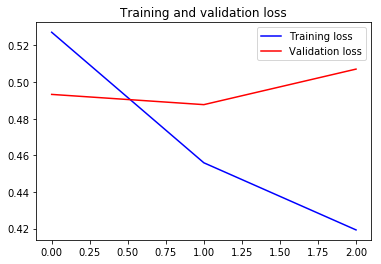

In [17]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### We can tune and Train more epochs (epochs=6)

In [18]:
history = model.fit(X_train, y_train, epochs=5,validation_split=0.1, batch_size=batch_size, verbose=1,callbacks=callbacks)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 43200 samples, validate on 4800 samples
Epoch 1/5
43200/43200 [==============================] - 322s 7ms/step - loss: 0.3860 - accuracy: 0.8232 - val_loss: 0.5122 - val_accuracy: 0.7558
Epoch 2/5


C:\Users\PC\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


43200/43200 [==============================] - 317s 7ms/step - loss: 0.3546 - accuracy: 0.8384 - val_loss: 0.5751 - val_accuracy: 0.7548
Epoch 3/5
43200/43200 [==============================] - 330s 8ms/step - loss: 0.3233 - accuracy: 0.8545 - val_loss: 0.5846 - val_accuracy: 0.7494
Epoch 4/5
43200/43200 [==============================] - 323s 7ms/step - loss: 0.2952 - accuracy: 0.8692 - val_loss: 0.6421 - val_accuracy: 0.7462
Epoch 5/5
43200/43200 [==============================] - 321s 7ms/step - loss: 0.2688 - accuracy: 0.8794 - val_loss: 0.6910 - val_accuracy: 0.7419
Accuracy: 73.62%


## Confusion Matrix (Tuned Model)

12000/12000 [==============================] - 10s 849us/step
Confusion matrix:
[[4430 1629]
 [1536 4405]]
mean: 0.5
1-mean: 0.5


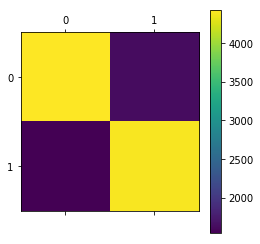

             precision    recall  f1-score   support

          0       0.74      0.73      0.74      6059
          4       0.73      0.74      0.74      5941

avg / total       0.74      0.74      0.74     12000



In [19]:
y_pred_1d = []
y_test_1d = list(y_test)
scores = model.predict(X_test, verbose=1, batch_size=8000)
y_pred_1d = [pred(score) for score in scores]


y_test_v = [valp(p) for p in y_test]
y_pred_v = [valp(p) for p in y_pred_1d]
cm = metrics.confusion_matrix(y_test_v, y_pred_v)
print("Confusion matrix:")
print(cm)
print("mean: "+str(y_test.mean()))
print("1-mean: "+str(1-y_test.mean()))
pl.matshow(cm)
#pl.title('Confusion matrix of the classifier')
pl.colorbar()
pl.show()
print(metrics.classification_report(y_test_v, y_pred_v))

### Improvements we could implement
* Weight classes (because data is skew)
* Train more epochs
* Use bigger network
* Try other word number

# Question 3

In [20]:
!pip install tweepy

In [21]:
import tweepy
from tweepy import OAuthHandler

consumer_key = 'DX8snsfc5tS1HZLwh3Smv5kIm'
consumer_secret = 'jFgJa36aCy81BwDoVQaV2KXORILBqZytbj18f7F68yctBhAZ5v'
access_token = '915695525747359744-YhdmKVnD85PmOZFhCrs9Je3WZvORq58'
access_secret = '3wfubaVXRnI3uEfl3k7ZSUgz2bPrkJDe0VSlXuhAzqEmu'

auth = OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_secret)
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

# Collecting tweets
We use Twitter streaming API to collect 15,000 tweets. We store each tweet that arrives in a file named 'analysis.json'. To be able to analyze the most popular terms for each sentiment, we first collect 7,500 tweets that we expect to be positive, and then we collect 7,500 tweets that we expect to be negative. We "classify" the tweets by using simple positive and negative dictionaries.

In [22]:
# Global variables to retrain the number of tweets we collect
tweet_count = 0
# Input number of tweets to be downloaded
n_tweets = 7500

# Erasing the files contents
open('positive.json', 'w').close
open('negative.json', 'w').close


#override tweepy.StreamListener to add logic to on_status
class MyStreamListener(tweepy.StreamListener):

    def __init__(self, file_name):
        self.file_name = file_name
        
    
    def on_data(self, data):
        global tweet_count
        global n_tweets
        global myStream
        if tweet_count < n_tweets:
            try:
                with open(self.file_name, 'a') as f:
                    f.write(data)
                    tweet_count += 1
                    return True
            except BaseException as e:
                print("Error on_data: %s" % str(e))
            return True
        else:
            myStream.disconnect()
            
    
    def on_error(self, status):
        print(status)
        return True 
    
    def on_exception(self, exception):
        print(exception)
        return


Collecting 7,500 positive tweets, and storing them in a file named 'positive.json'.
We use a simple dictionary to filter the positive tweets.

In [23]:
myStreamListener = MyStreamListener('positive.json')

while tweet_count < n_tweets:
    myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)
    try:
        myStream.filter(track=['good', 'nice', 'great', 'awesome', 'outstanding','impressive','fantastic', 
                       'terrific', 'like', 'love'])
    except Exception as e:
        continue

print('done!')

done!


Collecting 7,500 negative tweets, and storing them in a file named 'negative.json'.
We use a simple dictionary to filter the negative tweets.

In [24]:
myStreamListener = MyStreamListener('negative.json')

tweet_count = 0

while tweet_count < n_tweets:
    myStream = tweepy.Stream(auth = api.auth, listener=myStreamListener)
    try:
        myStream.filter(track=['bad', 'terrible', 'crap', 'useless', 'hate', 'disappointing', 'sad', 'mad'])
    except Exception as e:
        continue
        
print('done!')

done!


After storing 15,000 tweets in the files, we reed each tweet from the files, as a JSON object, and store the objects in positive and negative arrays.

In [25]:
import json

positive_data = []
negative_data = []

with open('positive.json', 'r') as f:
    for line in f:
        if len(line) <= 0 or line == '\n':
            continue
        positive_data.append(json.loads(line))
        
with open('negative.json', 'r') as f:
    for line in f:
        if len(line) <= 0 or line == '\n':
            continue
        negative_data.append(json.loads(line))


## Preprocessing
We use the same preprocessing as in question 1 to normalize the text of each tweet we collected.

In [26]:
positive_tweets = []
negative_tweets = []

for tweet in positive_data:
    if 'text' in tweet:
        positive_tweets.append(stem(preprocess(tweet['text'])))
        
for tweet in negative_data:
    if 'text' in tweet:
        negative_tweets.append(stem(preprocess(tweet['text'])))

print('Positive tweets:')
print(positive_tweets[:5])
print('Negative tweets:')
print(negative_tweets[:5])

Positive tweets:
['__userhandl love watch peopl throw up…', '__userhandl hair inspo like url', 'dog pizza box like __userhandl adoptdontshop url', 'hink bout like got enemi say （俺は誰か敵を作ったっけ？ どこかで何かしたっけ、何か言ったっ… url', "__userhandl trump n't think good idea particip someth like"]
Negative tweets:
['__userhandl bad bunni quier que llore por vaya perrear pute que haga que gana junto', '__userhandl banganya', "__userhandl __userhandl 're mad viru n't reach intend target depopul agenda african fa…", '__userhandl __userhandl', 'así daré una oportunidad bad bunni url']


## Analyzing popular terms
To analyze the most popular terms for each sentiment, we perform a simple count word for each array (positive/negative).

In [27]:
from collections import Counter

count_positive = Counter()
for tweet in positive_tweets:
    terms = tweet.split() 
    if 'url' in terms:
        terms.remove('url')
    count_positive.update(terms)

count_negative = Counter()
for tweet in negative_tweets:
    terms = tweet.split() 
    if 'url' in terms:
        terms.remove('url')
    count_negative.update(terms)


print('Most popular terms for positive sentiment:')
print(count_positive.most_common(10))
print('Most popular terms for negative sentiment:')
print(count_negative.most_common(10))

Most popular terms for positive sentiment:
[('__userhandl', 7714), ('like', 2469), ('love', 1558), ('good', 1116), ('great', 474), ('look', 410), ('march', 383), ('get', 361), ("n't", 319), ('one', 303)]
Most popular terms for negative sentiment:
[('__userhandl', 7347), ('bad', 2674), ('hate', 1235), ('bunni', 1187), ('que', 806), ('sad', 639), ('mad', 552), ('like', 470), ('peopl', 381), ('get', 357)]


## Terms Frequency 

In [28]:
positive_vec = TfidfVectorizer()
positive_terms = positive_vec.fit_transform(positive_tweets)

feature_names = positive_vec.get_feature_names()

df = pd.DataFrame(positive_terms.T.todense(), index=feature_names)
#Export data to csv
#df.to_csv(path + '\\stream_positive_freq.csv')

print("Terms frequency for positive sentiment:")
df

Terms frequency for positive sentiment:


,0,1,2,3,4,5,6,7,8,9,...,7343,7344,7345,7346,7347,7348,7349,7350,7351,7352
00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08056002020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08056003030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0805x1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
negative_vec = TfidfVectorizer()
negative_terms = negative_vec.fit_transform(negative_tweets)

feature_names = negative_vec.get_feature_names()

df = pd.DataFrame(negative_terms.T.todense(), index=feature_names)
#Export data to csv
#df.to_csv(path + '\\stream_negative_freq.csv')

print("Terms frequency for negative sentiment:")
df

Terms frequency for negative sentiment:


,0,1,2,3,4,5,6,7,8,9,...,7408,7409,7410,7411,7412,7413,7414,7415,7416,7417
00,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
001,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
008,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00am,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
07,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0822,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100,0.0,0.0,0.0,0.0,0.0,0.307448,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100hour,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We notice that in the tweets we collected there are much less emoticons than in the tweets in the training set.

# Question 4

The best sentiment classification prediction model which was trained in question 2 is the Naive Bayes model with the default alpha parameter (alpha = 1). We use it to predict the sentiment of the tweets we collected.


In [30]:
X_test = vec.transform(positive_tweets + negative_tweets)
Y_test = [4] * len(positive_tweets) + [0] * len(negative_tweets)

pred = nb.predict(X_test)

print('Accuracy score:')
print(metrics.accuracy_score(Y_test, pred))

Accuracy score:
0.7054363279398822


In [31]:
print('Confusion matrix:')
cm = metrics.confusion_matrix(Y_test, pred)

print(metrics.classification_report(Y_test, pred))

Confusion matrix:
             precision    recall  f1-score   support

          0       0.70      0.72      0.71      7418
          4       0.71      0.69      0.70      7353

avg / total       0.71      0.71      0.71     14771



## Conclusions

Twitter Streaming API is very dynamic, everytime we collected tweets, they were different from the training set and from each other. We could see the differences in the terms frequency. That (among others) makes Twitter sentiment analysis challenging.
Using the best prediction model that we trained in question 2, we managed to get a pretty good accuracy score - not far from the accuracy score we got on that model when we trained and tested it.